In [3]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans, AgglomerativeClustering
from Assignment_1_1 import compute_distance
import pandas as pd

In [69]:
def build_network_kmeans(measure_preference = 'similarity', threshold_value = 0.6, n_clusters=4):
    use_similarity = (measure_preference == 'similarity')
    mean_per_case = pd.read_csv("outputs_task_similarity_nb/resource_activity_mean_per_case.csv")
    matrix = mean_per_case.set_index('resource')
    weights = compute_distance(matrix=matrix, metric=measure_preference)

    kmeans = KMeans(n_clusters = n_clusters)
    clusters = kmeans.fit_predict(weights)    
    colors_activity = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    node_colors_activity = [colors_activity[i] 
                            for i in clusters]
    G = nx.Graph()
    for r in weights.index:
        G.add_node(r)

    nodes = list(weights.index)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            u, v = nodes[i], nodes[j]
            w = float(weights.loc[u, v])
            if use_similarity:
                if w >= threshold_value:
                    G.add_edge(u, v, weight=w)
            else:
                if w <= threshold_value:
                    G.add_edge(u, v, weight=w)

    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    pos = nx.spring_layout(G, seed=42)
    edge_w = [1 + 2 * max(0.0, (d.get('weight', 1.0) - threshold_value)) if use_similarity else 1 for _,_,d in G.edges(data=True)]
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors_activity)
    nx.draw_networkx_edges(G, pos, width=[w for w in edge_w], alpha=0.7)
    #nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("K-Means clustering of Resource Similarity")
    plt.show()
    return G

In [70]:
def build_network_hierarch(measure_preference = 'similarity', threshold_value = 0.6, n_clusters=4):
    use_similarity = (measure_preference == 'similarity')
    mean_per_case = pd.read_csv("outputs_task_similarity_nb/resource_activity_mean_per_case.csv")
    matrix = mean_per_case.set_index('resource')
    weights = compute_distance(matrix=matrix, metric=measure_preference)
    hierarchical_ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = hierarchical_ward.fit_predict(weights)
    colors_activity = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    node_colors_activity = [colors_activity[i] 
                            for i in clusters]
    G = nx.Graph()
    for r in weights.index:
        G.add_node(r)

    nodes = list(weights.index)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            u, v = nodes[i], nodes[j]
            w = float(weights.loc[u, v])
            if use_similarity:
                if w >= threshold_value:
                    G.add_edge(u, v, weight=w)
            else:
                if w <= threshold_value:
                    G.add_edge(u, v, weight=w)

    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    pos = nx.spring_layout(G, seed=42)
    edge_w = [1 + 2 * max(0.0, (d.get('weight', 1.0) - threshold_value)) if use_similarity else 1 for _,_,d in G.edges(data=True)]
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors_activity)
    nx.draw_networkx_edges(G, pos, width=[w for w in edge_w], alpha=0.7)
    #nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Hierarchical Clustering of Resource Similarity")

    plt.show()
    return G

Nodes: 134, Edges: 2917


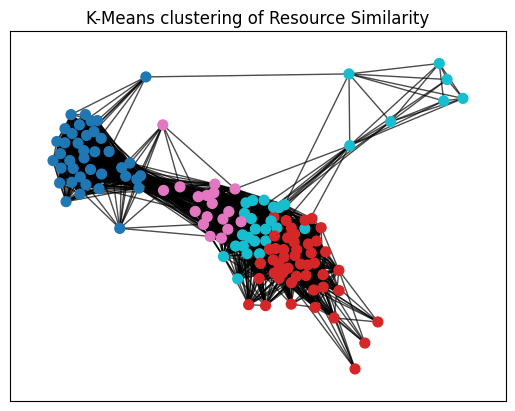

c:\Users\daang\OneDrive - TU Eindhoven\Documents\MSC\Process Mining\ProcessMining\.venv\Lib\site-packages\scipy\cluster\hierarchy.py:810: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Nodes: 134, Edges: 2917


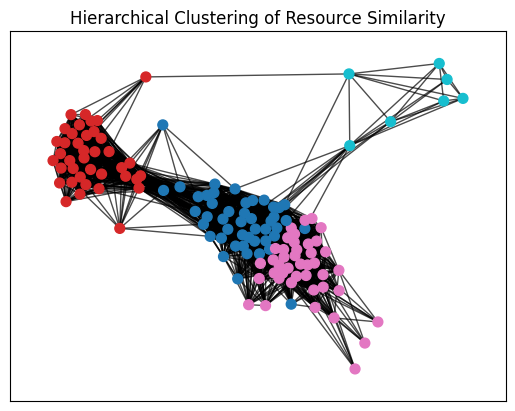

In [71]:
build_network_kmeans(measure_preference = 'hamming', threshold_value = 0.4, n_clusters=4)
build_network_hierarch(measure_preference = 'hamming', threshold_value = 0.4, n_clusters=4)


In [72]:
def build_network_hierarch(threshold_value = 0.0001, n_clusters=4, directed=True, show_unconnected_nodes = True):
    handover = pd.read_csv("outputs_task_similarity_nb/handover_matrix.csv")
    weights = handover.set_index('Unnamed: 0')
    
    # Perform clustering
    hierarchical_ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    clusters = hierarchical_ward.fit_predict(weights)
    
    # Create a mapping from node name to cluster
    node_to_cluster = dict(zip(weights.index, clusters))
    
    colors_activity = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    G = nx.DiGraph() if directed else nx.Graph()
    
    if directed:
        for src in weights.index:
            for dst in weights.columns:
                w = weights.at[src, dst]
                if w >= threshold_value and w > 0:
                    G.add_edge(src, dst, weight=float(w))
        if show_unconnected_nodes:
            for node in weights.index:
                G.add_node(node)
    else:
        visited = set()
        for a in weights.index:
            for b in weights.columns:
                if (a, b) in visited or (b, a) in visited:
                    continue
                w = (weights.at[a, b] + weights.at[b, a]) / 2.0
                if w >= threshold_value and w > 0:
                    G.add_edge(a, b, weight=float(w))
                visited.add((a, b))
        if show_unconnected_nodes:
            for node in weights.index:
                G.add_node(node)
    
    # Create node colors based on the cluster mapping
    node_colors_activity = [colors_activity[node_to_cluster[node]] for node in G.nodes()]
    
    pos = nx.spring_layout(G, seed=42)
    edge_weights = [G[u][v]['weight'] for u,v in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors_activity)
    nx.draw_networkx_edges(G, pos, width=[w*100 for w in edge_weights], alpha=0.7)
    plt.title("Hierarchical clustering of Activity Handover")

    plt.show()
    
    return G

def build_network_kmeans(threshold_value = 0.6, n_clusters=4, directed=True, show_unconnected_nodes = True):
    handover = pd.read_csv("outputs_task_similarity_nb/handover_matrix.csv")
    weights = handover.set_index('Unnamed: 0')  # Changed from 'resource' to match hierarch
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(weights)
    
    # Create a mapping from node name to cluster
    node_to_cluster = dict(zip(weights.index, clusters))
    
    colors_activity = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    G = nx.DiGraph() if directed else nx.Graph()
    
    if directed:
        for src in weights.index:
            for dst in weights.columns:
                w = weights.at[src, dst]
                if w >= threshold_value and w > 0:
                    G.add_edge(src, dst, weight=float(w))
        if show_unconnected_nodes:
            for node in weights.index:
                G.add_node(node)
    else:
        visited = set()
        for a in weights.index:
            for b in weights.columns:
                if (a, b) in visited or (b, a) in visited:
                    continue
                w = (weights.at[a, b] + weights.at[b, a]) / 2.0
                if w >= threshold_value and w > 0:
                    G.add_edge(a, b, weight=float(w))
                visited.add((a, b))
        if show_unconnected_nodes:
            for node in weights.index:
                G.add_node(node)
    
    # Create node colors based on the cluster mapping
    node_colors_activity = [colors_activity[node_to_cluster[node]] for node in G.nodes()]
    
    pos = nx.spring_layout(G, seed=42)
    edge_weights = [G[u][v]['weight'] for u,v in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors_activity)
    nx.draw_networkx_edges(G, pos, width=[w*100 for w in edge_weights], alpha=0.7)
    plt.title("K-Means clustering of Activity Handover")

    plt.show()
    
    return G

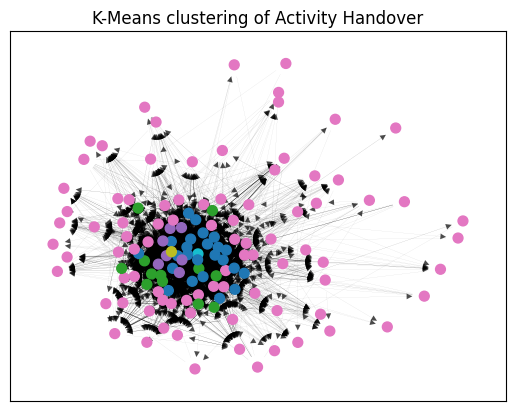

In [73]:
build_network_kmeans(n_clusters=6, threshold_value=0.0001,show_unconnected_nodes=False)

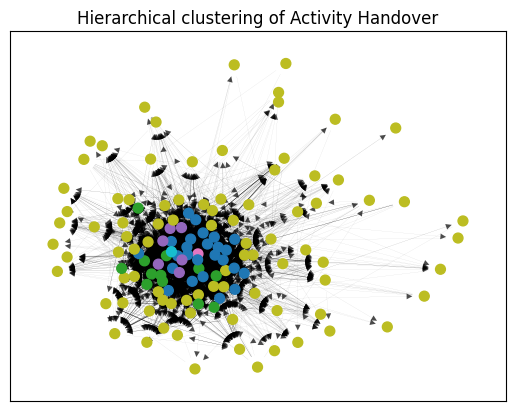

In [74]:
build_network_hierarch(n_clusters=6, threshold_value=0.0001,show_unconnected_nodes=False)

In [121]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

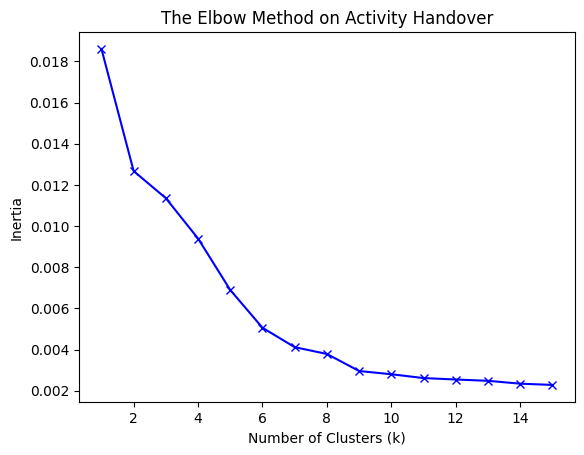

In [22]:
handover = pd.read_csv("outputs_task_similarity_nb/handover_matrix.csv")
weights = handover.set_index('Unnamed: 0')

inertias = []
mapping = {}
K = range(1, 16)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(weights)
    
    
    inertias.append(kmeanModel.inertia_)
    
    mapping[k] = inertias[-1]

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method on Activity Handover')
plt.show()

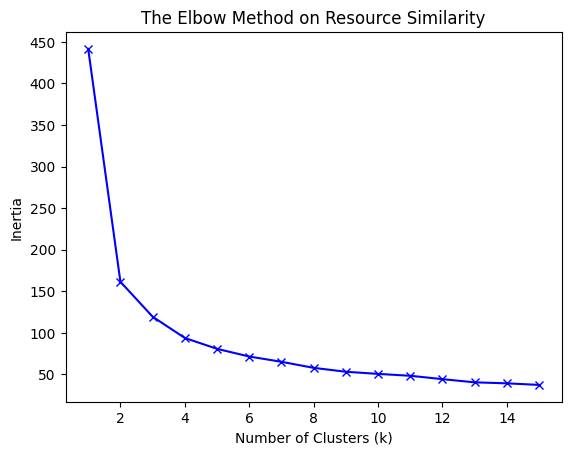

In [ ]:
mean_per_case = pd.read_csv("outputs_task_similarity_nb/resource_activity_mean_per_case.csv")
matrix = mean_per_case.set_index('resource')
weights = compute_distance(matrix=matrix, metric='hamming')

inertias = []
mapping = {}
K = range(1, 16)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(weights)
    
    
    inertias.append(kmeanModel.inertia_)
    
    mapping[k] = inertias[-1]

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method on Resource Similarity')
plt.show()